## Importing and prepping data

In [8]:
import pandas as pd
import numpy as np
import diff_classifier.aws as aws
import diff_classifier.pca as pca
from scipy import stats

In [2]:
features = []
remote_folder = 'ferret_tracking' #Folder in AWS S3 containing files to be analyzed
bucket = 'ccurtis.data'
filename = 'CatWalk_cleaned.csv'
    
#aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name='ccurtis.data')
fstats = pd.read_csv(filename, encoding = "ISO-8859-1")       

In [ ]:
fstats

In [5]:
#fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
nonnum = ['Litter', 'Ferret', 'Number', 'Sex', 'Rx', 'Experiment', 'Trial']
fstats_num = fstats.drop(nonnum, axis=1)
fstats_raw = fstats_num.as_matrix()
#fstats

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

for i in range(5):
    for col in fstats_num.columns:
        xmean = np.mean(fstats_num[col])
        xstd = np.std(fstats_num[col])

        counter = 0
        for x in fstats_num[col]:
            if x > xmean + 10*xstd:
                print(x)
                fstats[col][counter] = np.nan
                fstats_num[col][counter] = np.nan
                print(counter)
            if x < xmean - 10*xstd:
                print(x)
                fstats[col][counter] = np.nan
                fstats_num[col][counter] = np.nan
            counter = counter + 1

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [6]:
pcadataset = pca.pca_analysis(fstats, dropcols=nonnum, out_thresh=6, n_components=26)
ncomp = 26

Cumulative explained variance:
0 component: 0.16756979195684985
1 component: 0.3019476561423841
2 component: 0.39839654542792746
3 component: 0.4551856500931591
4 component: 0.49066249533752726
5 component: 0.5214822562627549
6 component: 0.5480480264820382
7 component: 0.5729870589410732
8 component: 0.5957665776339531
9 component: 0.6168705291390671
10 component: 0.6365786984849243
11 component: 0.6543889520102942
12 component: 0.6705691354478831
13 component: 0.6862320132238957
14 component: 0.6997274211133775
15 component: 0.712913915446072
16 component: 0.7251158684301676
17 component: 0.7361623402671034
18 component: 0.7469066950126043
19 component: 0.75677806225279
20 component: 0.7664447634873451
21 component: 0.7752870835361847
22 component: 0.7835206338882855
23 component: 0.7912028647865875
24 component: 0.7984872257180665
25 component: 0.8054465110551429


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [ ]:
kmostat = pca.kmo(pcadataset.scaled)

In [10]:
fstats_list = []
for num in range(0, pcadataset.scaled.shape[0]):
    fstats_list.append(pcadataset.scaled[num, :])

In [11]:
stats.bartlett(*fstats_list)

BartlettResult(statistic=10176.613295999496, pvalue=0.0)

In [158]:
pcadataset.prcomps.values[:, 15]

array(['RF_MeanIntensityOfThe15MostIntensePixels_SD',
       'RH_PrintLength_(cm)_SD', 'RF_MaxIntensity_SD',
       'RF_MaxContactMaxIntensity_SD', 'RF_MaxContactMeanIntensity_SD'], dtype=object)

In [15]:
pcadataset.prvals

{0: array([-0.11609193,  0.10840442,  0.10818898,  0.10776266,  0.10693419]),
 1: array([-0.10211941,  0.10153297,  0.10133928, -0.10093681,  0.10076766]),
 2: array([ 0.1229222 ,  0.11545632,  0.11408525,  0.11263386,  0.11237699]),
 3: array([-0.1728826 , -0.1581232 ,  0.12941259,  0.12064356, -0.11479374]),
 4: array([ 0.17546173,  0.16562955,  0.16226007,  0.15997701,  0.14132172]),
 5: array([-0.15964543, -0.15481614,  0.14917103,  0.14082261,  0.14025086]),
 6: array([ 0.1414165 ,  0.1374519 , -0.1373364 ,  0.13663607,  0.13627165]),
 7: array([ 0.19890726, -0.19858954, -0.1953664 , -0.18361096, -0.18040246]),
 8: array([-0.14603232, -0.14235722, -0.13602304, -0.13547314,  0.13202324]),
 9: array([ 0.17999816,  0.15691476,  0.15385356,  0.14187   ,  0.13877882]),
 10: array([ 0.14265798,  0.14028094,  0.13729805, -0.13619474, -0.13589561]),
 11: array([ 0.18024885, -0.15439387, -0.15313855, -0.15122268, -0.14818961]),
 12: array([-0.14930912, -0.14390781, -0.14022249,  0.13972841

## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [161]:
import numpy as np
dicti = {}
dicti[0] = np.nanmean(pcadataset.final[(pcadataset.final['Rx']=='Control') &
                                       (pcadataset.final['Sex']=='M')].values[:, -ncomp:].astype(float), axis=0)
dicti[1] = np.nanmean(pcadataset.final[(pcadataset.final['Rx']=='Control') &
                                       (pcadataset.final['Sex']=='F')].values[:, -ncomp:].astype(float), axis=0)
dicti[2] = np.nanmean(pcadataset.final[(pcadataset.final['Rx']=='Treated') &
                                       (pcadataset.final['Sex']=='M')].values[:, -ncomp:].astype(float), axis=0)
dicti[3] = np.nanmean(pcadataset.final[(pcadataset.final['Rx']=='Treated') &
                                       (pcadataset.final['Sex']=='F')].values[:, -ncomp:].astype(float), axis=0)

dicti[0] = dicti[0][new_order]
dicti[1] = dicti[1][new_order]
dicti[2] = dicti[2][new_order]
dicti[3] = dicti[3][new_order]

In [178]:
fstats_raw.shape

(170, 350)

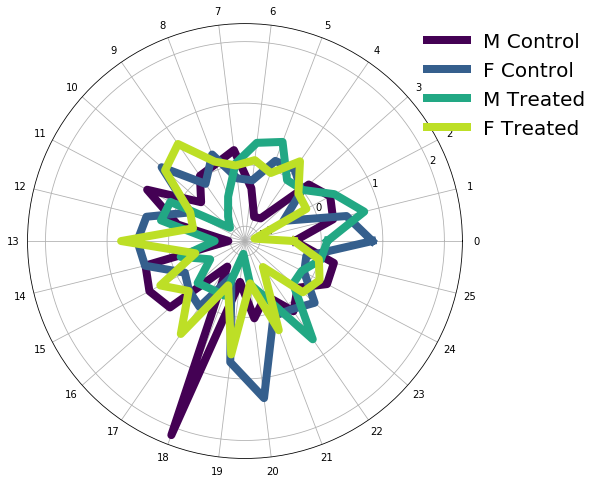

In [162]:
pca.plot_pca(dicti, savefig=True, labels=['M Control', 'F Control', 'M Treated', 'F Treated'], rticks=np.linspace(-1, 2, 4))

In [68]:
for feat in range(0, ncomp):
    test1 = pcadataset.final[(pcadataset.final['Rx']=='Control') &
                     (pcadataset.final['Sex']=='M')].values[:, -ncomp:].astype(float)[:, feat]
    
    test2 = pcadataset.final[(pcadataset.final['Rx']=='Treated') &
                     (pcadataset.final['Sex']=='M')].values[:, -ncomp:].astype(float)[:, feat]
    pval = stats.ttest_ind(test1, test2).pvalue
    if pval < 0.05:
        print('For Component', feat, pval)

For Component 15 0.0478484790685


In [69]:
for feat in range(0, ncomp):
    test1 = pcadataset.final[(pcadataset.final['Rx']=='Control') &
                     (pcadataset.final['Sex']=='F')].values[:, -ncomp:].astype(float)[:, feat]
    
    test2 = pcadataset.final[(pcadataset.final['Rx']=='Treated') &
                     (pcadataset.final['Sex']=='F')].values[:, -ncomp:].astype(float)[:, feat]
    pval = stats.ttest_ind(test1, test2).pvalue
    if pval < 0.05:
        print('For Component', feat, pval)

For Component 6 0.0036483332421
For Component 14 0.0413507785504
For Component 21 0.0164423635215


In [70]:
for feat in range(0, ncomp):
    test1 = pcadataset.final[(pcadataset.final['Rx']=='Control')].values[:, -ncomp:].astype(float)[:, feat]
    
    test2 = pcadataset.final[(pcadataset.final['Rx']=='Treated')].values[:, -ncomp:].astype(float)[:, feat]
    pval = stats.ttest_ind(test1, test2).pvalue
    if pval < 0.05:
        print('For Component', feat, pval)

For Component 6 0.0056342685904
For Component 14 0.0315416643065


In [155]:
pcadataset.prvals

{0: array([-0.11609193,  0.10840442,  0.10818898,  0.10776266,  0.10693419]),
 1: array([-0.10211941,  0.10153297,  0.10133928, -0.10093681,  0.10076766]),
 2: array([ 0.1229222 ,  0.11545632,  0.11408525,  0.11263386,  0.11237699]),
 3: array([-0.1728826 , -0.1581232 ,  0.12941259,  0.12064356, -0.11479374]),
 4: array([ 0.17546173,  0.16562955,  0.16226007,  0.15997701,  0.14132172]),
 5: array([-0.15964543, -0.15481614,  0.14917103,  0.14082261,  0.14025086]),
 6: array([ 0.1414165 ,  0.1374519 , -0.1373364 ,  0.13663607,  0.13627165]),
 7: array([ 0.19890726, -0.19858954, -0.1953664 , -0.18361096, -0.18040246]),
 8: array([-0.14603232, -0.14235722, -0.13602304, -0.13547314,  0.13202324]),
 9: array([ 0.17999816,  0.15691476,  0.15385356,  0.14187   ,  0.13877882]),
 10: array([ 0.14265798,  0.14028094,  0.13729805, -0.13619474, -0.13589561]),
 11: array([ 0.18024885, -0.15439387, -0.15313855, -0.15122268, -0.14818961]),
 12: array([-0.14930912, -0.14390781, -0.14022249,  0.13972841

In [49]:
import numpy as np
dicti = {}

new_order = [0, 2, 10, 22, 3, 4, 7, 19, 20, 8, 9, 11, 12, 13, 14, 15, 16, 24, 1, 5, 6, 17, 21, 23, 25, 19]
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pcadataset.final[(pcadataset.final['Rx']=='Control')].values[:, -ncomp:].astype(float), axis=0)
dicti[1] = np.nanmean(pcadataset.final[(pcadataset.final['Rx']=='Treated')].values[:, -ncomp:].astype(float), axis=0)

dicti[0] = dicti[0][new_order]
dicti[1] = dicti[1][new_order]

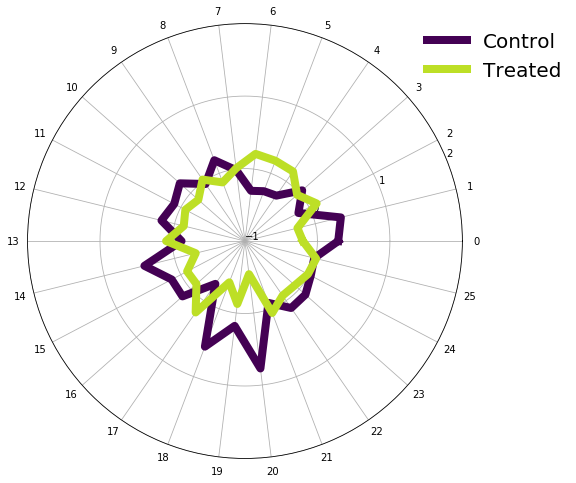

In [50]:
pca.plot_pca(dicti, savefig=True, labels=['Control', 'Treated'], rticks=np.linspace(-1, 2, 4))

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

In [ ]:
pcadataset.prcomps

In [25]:
import numpy as np
dicti = {}
dicti[0] = np.nanstd(pcadataset.final[pcadataset.final['Rx']=='Control'].values[:, -ncomp:].astype(float), axis=0)
dicti[1] = np.nanstd(pcadataset.final[pcadataset.final['Rx']=='Treated'].values[:, -ncomp:].astype(float), axis=0)

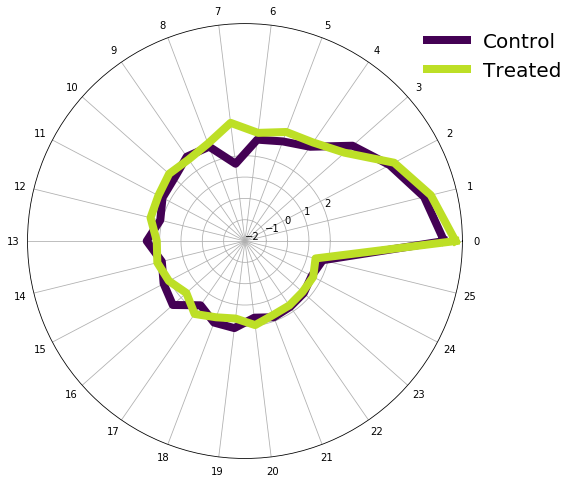

In [26]:
pca.plot_pca(dicti, savefig=True, labels=['Control', 'Treated'])

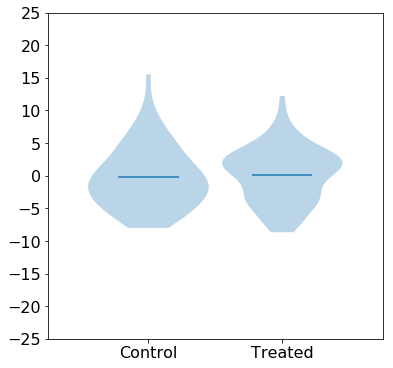

In [29]:
import diff_classifier.features as ft
tgroups = {}
tgroups[0] = pcadataset.final[pcadataset.final['Rx']=='Control']
tgroups[1] = pcadataset.final[pcadataset.final['Rx']=='Treated']
ft.feature_violin(tgroups, points=160, feature=3, ylim=[-25, 25], labels=['Control', 'Treated'], nticks=11)

In [150]:
temporal = [0, 2, 10, 22]
spatial = [3, 4, 7, 18, 20]
variation = [8, 9, 11, 12, 13, 14, 15, 16, 24]
coordination = [1, 5, 6, 17, 21, 23, 25, 19]

rxsex = []
featcol = []
valcol = []
feattype = []
for feat in range(ncomp):
    rxsex.extend(pcadataset.final['Sex'].values + ' ' + pcadataset.final['Rx'].values)
    featcol.extend([feat]*pcadataset.final['Sex'].values.shape[0])
    valcol.extend(pcadataset.final[feat].values)
    if feat in temporal:
        feattype.extend(['Temporal']*pcadataset.final['Sex'].values.shape[0])
    elif feat in spatial:
        feattype.extend(['Temporal']*pcadataset.final['Sex'].values.shape[0])
    elif feat in variation:
        feattype.extend(['Temporal']*pcadataset.final['Sex'].values.shape[0])
    else:
        feattype.extend(['Temporal']*pcadataset.final['Sex'].values.shape[0])
to_violind = {'RxSex': rxsex, 'Feature': featcol, 'Feature Value': valcol, 'Feature Type': feattype}
to_violin = pd.DataFrame(data=to_violind)


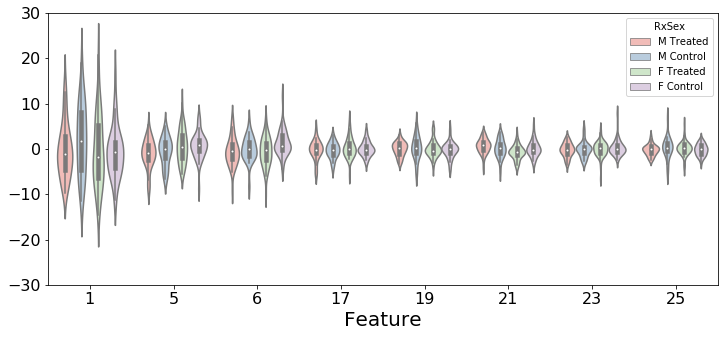

In [166]:
import seaborn as sns
f1 = 0
f2 = 5
fig, ax = plt.subplots(figsize=(12, 5))
hue_order = ['M Treated', 'M Control', 'F Treated', 'F Control']
sns.violinplot(x="Feature", y="Feature Value", hue="RxSex",
               #data=to_violin[(to_violin['Feature'] > f1 - 1) & (to_violin['Feature'] < f2 + 1)],
               data=to_violin[to_violin['Feature'].isin(coordination)],
               palette="Pastel1", hue_order=hue_order, figsize=(5, 40))
ax.tick_params(axis = 'both', which = 'major',
                     labelsize = 16)
plt.xlabel('Feature', fontsize=20)
plt.ylabel('', fontsize=20)
plt.ylim([-30, 30])
plt.savefig('testviolin.png')

In [31]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

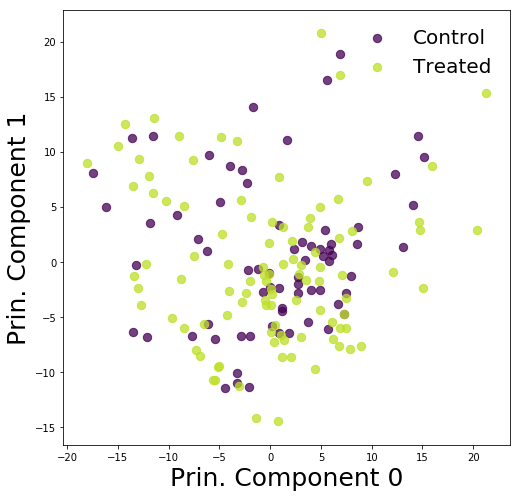

In [34]:
tgroups = {}
xy = {}
tgroups[0] = pcadataset.final[pcadataset.final['Rx']=='Control']
tgroups[1] = pcadataset.final[pcadataset.final['Rx']=='Treated']
N = len(tgroups)
color = iter(cm.viridis(np.linspace(0, 0.9, N)))

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
labels = ['Control', 'Treated']
counter = 0
for key in tgroups:
    c = next(color)
    xy = (tgroups[key][0], tgroups[key][1], tgroups[key][2])
    ax1 = plt.scatter(xy[0], xy[1], c=c, s=70, alpha=0.75, label=labels[counter])
    counter = counter + 1
    
#plt.xlim([-5, 5])
#plt.ylim([-5, 5])
plt.legend(fontsize=20, frameon=False)
plt.xlabel('Prin. Component 0', fontsize=25)
plt.ylabel('Prin. Component 1', fontsize=25)
plt.show()



In [ ]:
fstats_num[col][0]

In [ ]:
for col in pcadataset.final.columns:
    print(col)

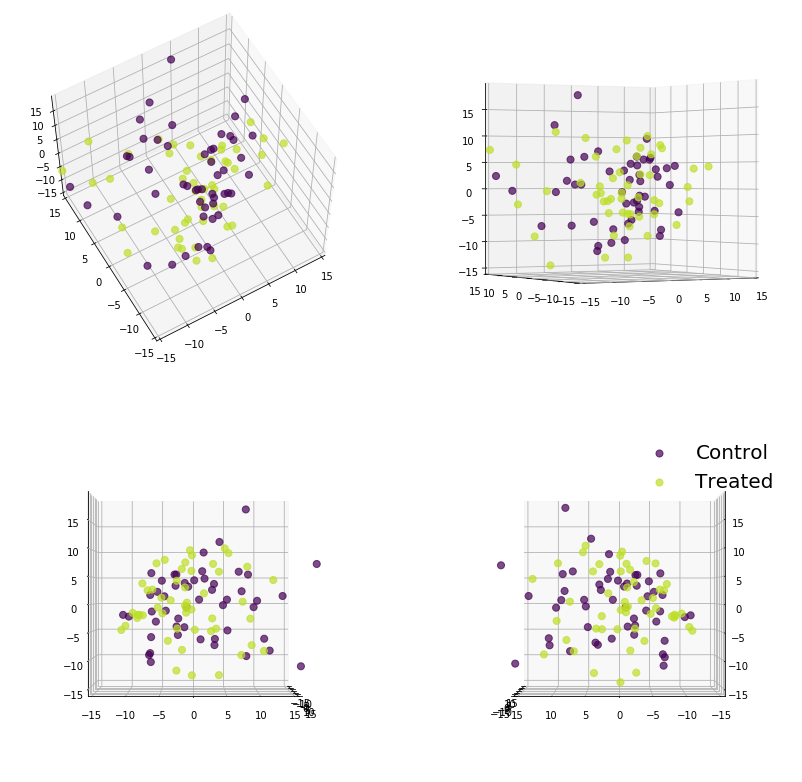

In [35]:
import random

axes = {}
fig = plt.figure(figsize=(14, 14))
axes[1] = fig.add_subplot(221, projection='3d')
axes[2] = fig.add_subplot(222, projection='3d')
axes[3] = fig.add_subplot(223, projection='3d')
axes[4] = fig.add_subplot(224, projection='3d')
color = iter(cm.viridis(np.linspace(0, 0.9, N)))
angle=240

angle1 = [60, 0, 0, 0]
angle2 = [240, 240, 0, 180]
labels = ['Control', 'Treated']
counter = 0
for key in tgroups:
    c = next(color)
    to_plot = random.sample(range(0, len(tgroups[key][0].tolist())), 50)
    xy = (list(tgroups[key][0].tolist()[i] for i in to_plot), 
          list(tgroups[key][1].tolist()[i] for i in to_plot),
          list(tgroups[key][2].tolist()[i] for i in to_plot))
    acount = 0
    for ax in axes:
        axes[ax].scatter(xy[0], xy[1], xy[2], c=c, s=50, alpha=0.7, label=labels[counter])
        axes[ax].set_xlim3d(-15, 15)
        axes[ax].set_ylim3d(-15, 15)
        axes[ax].view_init(angle1[acount], angle2[acount])
        acount = acount + 1
    counter = counter + 1

plt.legend(fontsize=20, frameon=False)
plt.show()

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
import random

In [ ]:
n_neighbors = 15

# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

In [ ]:
h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

In [ ]:
X.shape

In [ ]:
n_neighbors = 5
fvals = ['Control', 'Treated']


for fval in fvals:
    test = pcadataset.final[pcadataset.final['Rx']==fval].values[:, -21:]
    to_plot = np.array(random.sample(range(0, test.shape[0]), 35))
    if fval == 'Control':
        X = test[to_plot, :]
        y = pcadataset.final[pcadataset.final['Rx']==fval]['Rx'].values[to_plot]
    else:
        X = np.append(X, test[to_plot, :], axis=0)
        y = np.append(y, pcadataset.final[pcadataset.final['Rx']==fval]['Rx'].values[to_plot], axis=0)

col = y.shape[0]*[0]
for i in range(0, len(y)):
    if y[i]==100: col[i] = 0 
    elif y[i]==200: col[i] = 1 
    else: col[i] = 2

In [ ]:
clf = neighbors.KNeighborsClassifier(n_neighbors)
clf.fit(X, y)

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])


# # Plot the decision boundary. For that, we will assign a color to each
# # point in the mesh [x_min, x_max]x[y_min, y_max].
# x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                      np.arange(y_min, y_max, h))
# Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# # Put the result into a color plot
# Z = Z.reshape(xx.shape)
# plt.figure()
# plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# # Plot also the training points
# plt.scatter(X[:, 0], X[:, 1], c=col, cmap=cmap_bold,
#             edgecolor='k', s=20)
# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())
# plt.title("3-Class classification (k = %i)"
#           % (n_neighbors))

# plt.show()

In [ ]:
Z2 = clf.predict(X)

In [ ]:
correct = np.zeros(y.shape[0])

for i in range(0, y.shape[0]):
    if y[i] == Z2[i]:
        correct[i] = 1

pcorrect = np.average(correct)
print(pcorrect)

In [ ]:
test2 = pcadataset.final.values[:, -21:]
y2 = pcadataset.final['Rx'].values

Z3 = clf.predict(test2)
correct = np.zeros(y2.shape[0])

for i in range(0, y2.shape[0]):
    if y2[i] == Z3[i]:
        correct[i] = 1

pcorrect = np.average(correct)
print(pcorrect)

In [180]:
def build_KNN_model(rawdata, feature, featvals, equal_sampling=True,
                    tsize = 20, n_neighbors=5, from_end=True, input_cols=6):
    """
    
    """
    
    if equal_sampling:
        for featval in featvals:
            if from_end:
                test = rawdata[rawdata[feature]==featval].values[:, -input_cols:]
            else:
                test = rawdata[rawdata[feature]==featval].values[:, input_cols[0]:input_cols[1]]
            to_plot = np.array(random.sample(range(0, test.shape[0]), tsize))
            if featval == featvals[0]:
                X = test[to_plot, :]
                y = rawdata[rawdata[feature]==featval][feature].values[to_plot]
            else:
                X = np.append(X, test[to_plot, :], axis=0)
                y = np.append(y, rawdata[rawdata[feature]==featval][feature].values[to_plot], axis=0)
    
    else:
        if from_end:
            test = rawdata.values[:, -input_cols:]
        else:
            test = rawdata.values[:, input_cols[0]:input_cols[1]]
        to_plot = np.array(random.sample(range(0, test.shape[0]), tsize))
        X = test[to_plot, :]
        y = rawdata[feature].values[to_plot]
            
    clf = neighbors.KNeighborsClassifier(n_neighbors)
    clf.fit(X, y)
    
    return clf, X, y

In [39]:
KNNmod, X, Y = build_KNN_model(pcadataset.final, 'Rx', ['Control', 'Treated'], equal_sampling=True, tsize=35,
                                    n_neighbors=5, input_cols=21)

In [44]:
type(KNNmod)

sklearn.neighbors.classification.KNeighborsClassifier

In [181]:
def predict_KNN(model, X, y):
    """
    
    """
    yp = model.predict(X)
    correct = np.zeros(y.shape[0])
    for i in range(0, y.shape[0]):
        if y[i] == yp[i]:
            correct[i] = 1

    pcorrect = np.average(correct)
    #print(pcorrect)
    return pcorrect

In [186]:
trainp = np.array([])
testp = np.array([])

for i in range(0, 30):
    KNNmod, X, y = build_KNN_model(pcadataset.final, 'Rx', ['Control', 'Treated'], equal_sampling=True,
                             tsize=35, n_neighbors=5, input_cols=26)
    trainp = np.append(trainp, predict_KNN(KNNmod, X, y))
    
    X2 = pcadataset.final.values[:, -26:]
    y2 = pcadataset.final['Rx'].values
    testp = np.append(testp, predict_KNN(KNNmod, X2, y2))

In [187]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

0.6885714285714286 +/ 0.047150071598044054
0.5664705882352942 +/ 0.03310707524642653


In [ ]:
np.std(testp)

In [43]:
fstats

,Litter,Ferret,Number,Sex,Rx,Weight,Experiment,Time_Point,Trial,NumberOfRunsUsedForCalculatingTrialStatistics,...,Average Hindpaw Step Cycle,Front Stride Length,Hind Stride Length,Avg Stride Length,Stride Length SD,Stride Length CoV,Hindpaw Mean Intensity/Area/g,Avg Swing Speed,Avg Swing Speed SD,Swing Speed CoV
0,14,8,1,F,Control,185.8,Wood experiment,42,Trial0013,3.0,...,0.456180,12.108681,12.663759,12.386220,2.160542,17.443107,0.508319,105.648003,39.201683,37.105938
1,17,12,2,F,Control,276.4,Litter17_P42,42,Trial0001,3.0,...,0.432919,15.756602,15.768565,15.762584,2.201206,13.964754,0.318806,110.337314,25.846358,23.424857
2,17,14,3,F,Control,261.7,Litter17_P42,42,Trial0004,4.0,...,0.312338,15.282236,15.923034,15.602635,4.037811,25.879033,0.138349,111.762624,28.149727,25.187067
3,23,4,4,F,Control,361.1,Ferret 23,42,Trial0001,3.0,...,0.330237,17.858503,17.341952,17.600227,2.064597,11.730512,0.256824,132.336391,20.173085,15.243793
4,26,6,5,F,Control,232.0,Ferret 26,42,Trial0001,3.0,...,0.410423,16.467026,16.181332,16.324179,1.272255,7.793688,0.165579,104.007636,21.228592,20.410609
5,26,10,6,F,Control,245.0,Ferret 26,42,Trial0004,3.0,...,0.273743,17.649475,18.451179,18.050327,2.713893,15.035147,0.163078,137.504624,25.844392,18.795289
6,27,4,7,F,Control,187.0,Ferret 26,42,Trial0012,3.0,...,0.255330,14.735541,14.400537,14.568039,1.590193,10.915625,0.370553,123.218443,33.881515,27.497113
7,27,2,8,F,Control,287.0,Ferret 26,42,Trial0013,4.0,...,0.273536,17.722836,18.158425,17.940631,2.818857,15.712142,0.122231,153.068760,46.146695,30.147690
8,14,5,9,M,Control,308.3,Wood experiment,42,Trial0012,3.0,...,0.225737,16.771006,17.158522,16.964764,3.661076,21.580469,0.125341,164.964370,27.842038,16.877607
9,23,1,10,M,Control,450.3,Ferret 23,42,Trial0003,3.0,...,0.307501,17.270080,17.509993,17.390037,1.960371,11.272954,0.175463,159.185185,22.562969,14.174038


In [198]:
output = ['F']*1000 + ['M']*1000
data = {'output' : output,
        0 : np.append(np.random.normal(1, 1, size=1000), np.random.normal(1000, 1, size=1000)),
        1 : np.append(np.random.normal(0.1, 0.1, size=1000), np.random.normal(100, 0.1, size=1000))}
dataf = pd.DataFrame(data)

model, X, Y = build_KNN_model(dataf, 'output', ['F', 'M'], equal_sampling=False, tsize=25,
                               n_neighbors=5, input_cols=2)

In [184]:
predict_KNN(model, dataf.values[:, -2:], dataf.values[:, 0])

0.51649999999999996

In [199]:
testp = np.array([])

for i in range(0, 30):
    KNNmod, X, y = build_KNN_model(dataf, 'output', ['F', 'M'], equal_sampling=True,
                             tsize=25, n_neighbors=5, input_cols=2)
    #trainp = np.append(trainp, predict_KNN(KNNmod, X, y))
    
    X2 = dataf.values[:, -2:]
    y2 = dataf.values[:, 0]
    testp = np.append(testp, predict_KNN(KNNmod, X2, y2))
    
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

1.0 +/ 0.0


In [195]:
assert X.shape == (25, 2)

In [197]:
Y.shape == (25,)

True